# 4.1 Explanation Continuity

## Introduction

**This section corresponds to Section 7.1 of the original paper.**

What characterizes a good explanation? A first desirable property of an explanation technique is that if it is given two similar images, then its explanation must also be similar. Explanation continuity (or lack of it) can be quantified by looking for the strongest variation of the explanation $R(x)$ in the input domain:

\begin{equation}
\max_{x \neq x'} \frac{\lVert R(x) - R(x') \lVert_1}{\lVert x - x' \lVert_2}
\end{equation}

When $f(x)$ is a deep ReLU network, both sensitivity analysis and Simple Taylor Decomposition have sharp discontinuities in their explanation function while Deep Taylor Decomposition provides continuous explanations. Let us explore what this means with a simple function $f(\mathbf{x}) = \max (x_1, x_2)$ in $\mathbb{R}_2^+$, here implemented by the two-layer ReLU network

\begin{equation}
f(\mathbf{x}) = \max \left( 0, \frac{\max (0, x_1 - x_2) + \max (0, x_2 - x_1) + \max (0, x_1 + x_2)}{2} \right)
\end{equation}

![title](./assets/4_1_EC/net.jpg)

The network is comprised of three layers (input, hidden and output). The number at each line connecting the neurons indicates the associated weight value and the bent line denotes the use of ReLU activation function. $a_j$ and $b_k$ denote activations of the hidden and output layers respectively. Then, we can define the network as:

\begin{align}
a_1 & = \max (0, x_1 - x_2) \\
a_2 & = \max (0, x_2 - x_1) \\
a_3 & = \max (0, x_1 + x_2) = x_1 + x_2 \\
b_1 & = \max \left( 0, \frac{a_1 + a_2 + a_3}{2} \right) = \frac{a_1 + a_2 + a_3}{2} = \max (x_1, x_2)
\end{align}
We could remove the $\max$ in *Eqs. (5)* and *(6)* because $x_1$ and $x_2$ are guaranteed to be positive.


Now, we are ready to compare the various explanation techniques we convered throughout the tutorials. I will not calculate the relevance scores for Sensitivity Analysis and Simple Taylor Decomposition because they can be easily derived.

### Sensitivity Analysis

\begin{equation}
R(\mathbf{x}) =
\begin{cases}
(1,0) & \text{if} \ x_1 > x_2 \\
(0,1) & \text{if} \ x_1 < x_2
\end{cases}
\end{equation}

### Simple Taylor Decomposition

\begin{equation}
R(\mathbf{x}) =
\begin{cases}
(x_1,0) & \text{if} \ x_1 > x_2 \\
(0,x_2) & \text{if} \ x_1 < x_2
\end{cases}
\end{equation}

### Deep Taylor Decomposition

To derive the relevance at the input layer, we must backpropagate the function output throughout the layers using the Deep Taylor Decomposition rules. Since the input is constrained to be positive ($\mathbb{R}_2^+$) and we are using ReLU activation in rest of the layers, we only need to apply the $z^+$-rule.

#### Relevance propagation from output to hidden layer

The $z^+$-rule is given below:

\begin{equation}
R_{j \leftarrow k}^{(2,3)} = \frac{z_{jk}^+}{\sum_k z_{jk}^+} R_{k}^{(3)}
\end{equation}
where $z_{jk}^+ = a_j w_{jk}^+$ and where $w_{jk}^+$ denotes the positive part of $w_{jk}$.

By the *Layer-wise Relevance Conservation Constraint*, $R_k^{(3)} = b_1$. $\{z_{jk}^+\}$ and $\sum_j \{z_{jk}^+\}$ is given as follows:

\begin{equation}
\{z_{jk}^+\} = 
\begin{bmatrix}
\displaystyle \frac{a_1}{2} \\ \displaystyle \frac{a_2}{2} \\ \displaystyle \frac{a_3}{2}
\end{bmatrix}
\end{equation}

\begin{equation}
\sum_j \{z_{jk}^+\} = 
\begin{bmatrix}
\displaystyle \frac{\sum_j a_j}{2}
\end{bmatrix}
\end{equation}

Then $R_{j \leftarrow k}^{(2,3)} = R_{j}^{(2)}$ can be calculated with *Eq. (9)*.

\begin{equation}
R_{j}^{(2)} = 
\begin{bmatrix}
\displaystyle \frac{a_1}{\sum_j a_j} \cdot b_1 \\ \displaystyle \frac{a_2}{\sum_j a_j} \cdot b_1 \\ \displaystyle \frac{a_3}{\sum_j a_j} \cdot b_1
\end{bmatrix}
\end{equation}

#### Relevance propagation from hidden to input layer

The $z^+$-rule is given below:

\begin{equation}
R_{i \leftarrow j}^{(1,2)} = \frac{z_{ij}^+}{\sum_j z_{ij}^+} R_{j}^{(2)}
\end{equation}
where $z_{ij}^+ = x_i w_{ij}^+$ and where $w_{ij}^+$ denotes the positive part of $w_{ij}$.

$\{z_{ij}^+\}$ and $\sum_i \{z_{ij}^+\}$ is given as follows:

\begin{equation}
\{z_{ij}^+\} = 
\begin{bmatrix}
x_1 & 0 & x_1 \\
0 & x_2 & x_2
\end{bmatrix}
\end{equation}

\begin{equation}
\sum_i \{z_{ij}^+\} = 
\begin{bmatrix}
x_1 & x_2 & x_1 + x_2 \\
\end{bmatrix}
\end{equation}

Then $R_{i}^{(1)} = \sum_j R_{i \leftarrow j}^{(1,2)}$ can be calculated with *Eq. (13)*.

\begin{equation}
R_{i}^{(1)} = 
\begin{bmatrix}
\displaystyle \frac{a_1}{\sum_j a_j} \cdot b_1 + \frac{x_1}{x_1+x_2} \cdot \frac{a_3}{\sum_j a_j} \cdot b_1 \\
\displaystyle \frac{a_2}{\sum_j a_j} \cdot b_1 + \frac{x_2}{x_1+x_2} \cdot \frac{a_3}{\sum_j a_j} \cdot b_1
\end{bmatrix} =
\begin{bmatrix}
\displaystyle \frac{a_1}{2} + \frac{x_1}{x_1+x_2} \cdot \frac{a_3}{2} \\
\displaystyle \frac{a_2}{2} + \frac{x_2}{x_1+x_2} \cdot \frac{a_3}{2}
\end{bmatrix} =
\begin{bmatrix}
\displaystyle \frac{a_1 + x_1}{2} \\
\displaystyle \frac{a_2 + x_2}{2}
\end{bmatrix}
\end{equation}

This gives us the following relevance scores:

\begin{equation}
R(\mathbf{x}) =
\begin{cases}
\displaystyle \left( \frac{2 x_1 - x_2}{2}, \frac{x_2}{2} \right) & \text{if} \ x_1 > x_2 \\[1.5ex]
\displaystyle \left( \frac{x_1}{2}, \frac{- x_1 + 2 x_2}{2} \right) & \text{if} \ x_1 < x_2
\end{cases}
\end{equation}

Visualization of all three techniques gives us the following figure:

![title](./assets/4_1_EC/fig1.png)

It can be seen that despite the continuity of the prediction function, the explanations offered by Sensitivity Analysis and Simple Taylor Decomposition are discontinuous on the line $x_1 = x_2$. Only Deep Taylor Decomposition produces a smooth transition. In the Tensorflow walkthrough, we are going to demonstrate the continuity of explanation techniques in another way. We are first going to train a DNN to recognize MNIST digits. Then, we are going to compare explanations offered by different explanation techniques as we move a handwritten digit from left to right. If the technique satisfies explanation continuity, the explanations produced also must change continuously without sudden jumps.

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import numpy as np

from models.models_4_1 import MNIST_CNN, Taylor
from utils import translate

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/4_1_EQ/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('DTD', X)
    
    for activation in activations:
        tf.add_to_collection('DTD', activation)
    
    tf.add_to_collection('SA_STD', X)
    tf.add_to_collection('SA_STD', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.166183108 accuracy = 0.947363642
Epoch: 0002 cost = 0.044496261 accuracy = 0.986781827
Epoch: 0003 cost = 0.029138031 accuracy = 0.990672735
Epoch: 0004 cost = 0.022342106 accuracy = 0.992672734
Epoch: 0005 cost = 0.016914875 accuracy = 0.994436369
Epoch: 0006 cost = 0.014987342 accuracy = 0.994890914
Epoch: 0007 cost = 0.013461443 accuracy = 0.995527277
Epoch: 0008 cost = 0.008795333 accuracy = 0.996927276
Epoch: 0009 cost = 0.009626083 accuracy = 0.996854548
Epoch: 0010 cost = 0.007642976 accuracy = 0.997581820
Epoch: 0011 cost = 0.008112480 accuracy = 0.997290912
Epoch: 0012 cost = 0.007751439 accuracy = 0.997527275
Epoch: 0013 cost = 0.006631166 accuracy = 0.997781820
Epoch: 0014 cost = 0.006926514 accuracy = 0.997581820
Epoch: 0015 cost = 0.004724893 accuracy = 0.998418183
Accuracy: 0.9922


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

INFO:tensorflow:Restoring parameters from ./tf_logs/4_1_EQ/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

activations = tf.get_collection('DTD')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

Rs = [taylor(i) for i in range(10)]

nodes = tf.get_collection('SA_STD')
X = nodes[0]
logits = nodes[1]

SA_scores = tf.square(tf.gradients(logits, X))
STD_scores = tf.negative(tf.gradients(logits, X) * X)

### 6. Calculating Relevance Scores $R(x_i)$ and Displaying Images

We can see that while Sensitivity Analysis and Simple Taylor Decomposition provides discontinuous explanations with frequent jumps, Deep Taylor Decomposition gives us a continuous explanation.

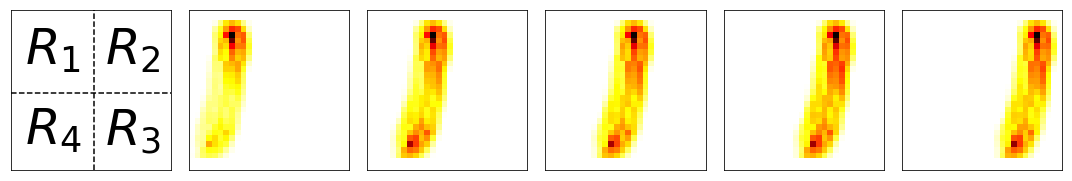

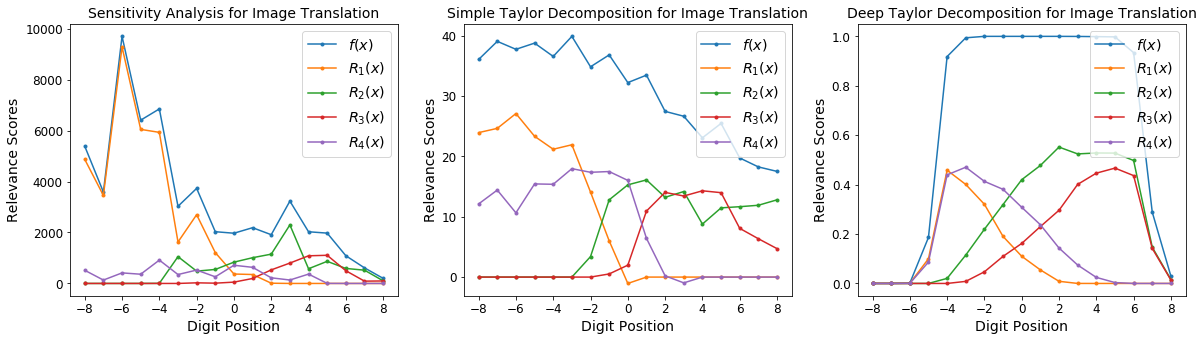

In [6]:
digit = 1
dist = 17
init = -8

images = mnist.train.images
labels = mnist.train.labels
sample_imgs = [images[np.argmax(labels, axis=1) == i][0] for i in range(10)]
translated_imgs = [[translate(img, init + i, 0) for i in range(dist)] for img in sample_imgs]

sa_imgs = [[sess.run(SA_scores, feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
sa_imgs = np.square(np.reshape(sa_imgs, [10, dist, -1]))

std_imgs = [[sess.run(STD_scores, feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
std_imgs = np.reshape(std_imgs, [10, dist, -1])

dtd_imgs = [[sess.run(Rs[i], feed_dict={X:translated_imgs[i][j]}) for j in range(dist)] for i in range(10)]
dtd_imgs = np.squeeze(dtd_imgs, axis=2)

sa_imgs_q0 = sa_imgs[digit]
sa_imgs_q1 = sa_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
sa_imgs_q2 = sa_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
sa_imgs_q3 = sa_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
sa_imgs_q4 = sa_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

std_imgs_q0 = std_imgs[digit]
std_imgs_q1 = std_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
std_imgs_q2 = std_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
std_imgs_q3 = std_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
std_imgs_q4 = std_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

dtd_imgs_q0 = dtd_imgs[digit]
dtd_imgs_q1 = dtd_imgs[digit].reshape(dist,28,28)[:,0:14,0:14].reshape(dist,-1)
dtd_imgs_q2 = dtd_imgs[digit].reshape(dist,28,28)[:,0:14,14:28].reshape(dist,-1)
dtd_imgs_q3 = dtd_imgs[digit].reshape(dist,28,28)[:,14:28,14:28].reshape(dist,-1)
dtd_imgs_q4 = dtd_imgs[digit].reshape(dist,28,28)[:,14:28,0:14].reshape(dist,-1)

fig = plt.figure(figsize=[15,15])
for i in range(6):
    if i is 0:
        ax = fig.add_subplot(1, 6, 1)
        ax.imshow(np.zeros([28,28]), cmap='gray_r', vmin=0, vmax=1)
        ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
        ax.axvline(14, linestyle='--', color='black')
        ax.axhline(14, linestyle='--', color='black')
        ax.text(2, 9, '$R_1$', fontdict={'fontsize': 50})
        ax.text(16, 9, '$R_2$', fontdict={'fontsize': 50})
        ax.text(16, 23, '$R_3$', fontdict={'fontsize': 50})
        ax.text(2, 23, '$R_4$', fontdict={'fontsize': 50})
        continue
        
    ax = fig.add_subplot(1, 6, i + 1)
    ax.imshow(dtd_imgs_q0[4 * (i - 1)].reshape([28,28]), cmap='hot_r')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()

fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(131)
x = list(range(init,init+dist))
y0 = np.sum(sa_imgs_q0, axis=1)
y1 = np.sum(sa_imgs_q1, axis=1)
y2 = np.sum(sa_imgs_q2, axis=1)
y3 = np.sum(sa_imgs_q3, axis=1)
y4 = np.sum(sa_imgs_q4, axis=1)

ax1.plot(x, y0, marker='.', label='$f(x)$')
ax1.plot(x, y1, marker='.', label='$R_1(x)$')
ax1.plot(x, y2, marker='.', label='$R_2(x)$')
ax1.plot(x, y3, marker='.', label='$R_3(x)$')
ax1.plot(x, y4, marker='.', label='$R_4(x)$')
ax1.legend(loc='upper right', fontsize='x-large')

ax1.set_title('Sensitivity Analysis for Image Translation', fontdict={'fontsize': 14})
ax1.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax1.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax1.tick_params(labelsize=12)

ax2 = fig.add_subplot(132)
y0 = np.sum(std_imgs_q0, axis=1)
y1 = np.sum(std_imgs_q1, axis=1)
y2 = np.sum(std_imgs_q2, axis=1)
y3 = np.sum(std_imgs_q3, axis=1)
y4 = np.sum(std_imgs_q4, axis=1)

ax2.plot(x, y0, marker='.', label='$f(x)$')
ax2.plot(x, y1, marker='.', label='$R_1(x)$')
ax2.plot(x, y2, marker='.', label='$R_2(x)$')
ax2.plot(x, y3, marker='.', label='$R_3(x)$')
ax2.plot(x, y4, marker='.', label='$R_4(x)$')
ax2.legend(loc='upper right', fontsize='x-large')

ax2.set_title('Simple Taylor Decomposition for Image Translation', fontdict={'fontsize': 14})
ax2.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax2.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax2.tick_params(labelsize=12)

ax3 = fig.add_subplot(133)
y0 = np.sum(dtd_imgs_q0, axis=1)
y1 = np.sum(dtd_imgs_q1, axis=1)
y2 = np.sum(dtd_imgs_q2, axis=1)
y3 = np.sum(dtd_imgs_q3, axis=1)
y4 = np.sum(dtd_imgs_q4, axis=1)

ax3.plot(x, y0, marker='.', label='$f(x)$')
ax3.plot(x, y1, marker='.', label='$R_1(x)$')
ax3.plot(x, y2, marker='.', label='$R_2(x)$')
ax3.plot(x, y3, marker='.', label='$R_3(x)$')
ax3.plot(x, y4, marker='.', label='$R_4(x)$')
ax3.legend(loc='upper right', fontsize='x-large')

ax3.set_title('Deep Taylor Decomposition for Image Translation', fontdict={'fontsize': 14})
ax3.set_xlabel('Digit Position', fontdict={'fontsize': 14})
ax3.set_ylabel('Relevance Scores', fontdict={'fontsize': 14})
ax3.tick_params(labelsize=12)

sess.close()